In [1]:
%matplotlib notebook
import os
import numpy as np
import chaospy as cp
import pandas as pd
import seaborn as sns
import itertools
import pickle
from numpy import linalg as LA
from matplotlib import pyplot as plt,cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm,SymLogNorm
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel,WhiteKernel)
pltlinestyles = [ (0, (1, 5)),(0, (3, 5, 1, 5)),(0, (5, 5)),(0, ()), (0, (3, 1, 1, 1, 1, 1)), 
        (0, (5, 10)), (0, (3, 10, 1, 10)), (0, (3, 10, 1, 10, 1, 10)),(0, (1, 10)), 
        (0, (5, 1)),  (0, (3, 1, 1, 1)),(0, (3, 5, 1, 5, 1, 5)),  (0, (1, 1))  ]*10

pltmarkers =['o','v','s','d','+','*']
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(math.floor(n/10)%10!=1)*(n%10<4)*n%10::4])
pltcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
figsize = (4*1.5,3*1.5)
pf = 1e-4

In [2]:
MODEL_NAME      = 'Bench1'
DATA_DIR        = '/Users/jinsongliu/External/MUSE_UQ_DATA'
# DATA_DIR        = 'G:\My Drive\MUSE_UQ_DATA'

MODEL_DIR_DATA  = os.path.join(DATA_DIR,MODEL_NAME,r'Data')
MODEL_DIR_FIGURE= os.path.join(os.getcwd(), MODEL_NAME,r'Figures')
print(MODEL_DIR_FIGURE)

# class Ecdf2plot: 
#     def __init__(self, x, y):
#         self.x = x
#         self.y = y

/Users/jinsongliu/BoxSync/MUSELab/museuq/examples/Bench1/Figures


##  Periodic function

\begin{equation}
\begin{aligned}
    f(x) &= x \sin(x) + \epsilon \\
    \epsilon \sim p(\epsilon), \mathbb{E}[\epsilon] &= 0, \mathrm{Var}[\epsilon] = \frac{1}{5}|f(x)|
\end{aligned}
\end{equation}

In [3]:
figsize = (4*1.5,3*1.5)
pf = 1e-4
noise_type = 'DATA_NOISE_FREE'
# x_fix = np.linspace(-5,15,1000)[np.newaxis, :]
# metamodel_class, metamodel_basis= ['PCE', [8,9,10]]
ndoe2plot = list(np.arange(10,16))

In [4]:
dist_x = cp.Normal(5,2)
print(dist_x.inv(pf/100),dist_x.inv(1-pf/100))

-4.506848617645797 14.506848617634175


In [ ]:
metamodel_class, metamodel_basis= ['PCE', ndoe2plot]
xlims, ylims = [-10,20], [-40,40] 
yDoE = np.linspace(ylims[0]*0.6,ylims[1]*0.8,len(ndoe2plot))
label_added =False

data_set = np.load(os.path.join(MODEL_DIR_DATA,r'bench1_noise_free.npy'))
print(data_set.shape)
x,y_mean = data_set[0],data_set[1]
print(x.shape, y_mean.shape)

fig1= plt.figure(figsize=figsize)
ax1 = fig1.add_subplot(1,1,1)
ax1.plot(x,y_mean,'k',label=r'f(x)')

# data_set = np.load(os.path.join(MODEL_DIR_DATA,r'bench1_normal.npy'))
# print(data_set.shape)
# x_samples,y_samples = data_set[0],data_set[1]
# std = data_set[4]

# ax1.plot(x_samples,y_samples,'-k',label=r'$f(x)+\epsilon$',alpha=0.5,linewidth=0.5)
# ax1.fill_between(x, y_mean + 1.96*std, y_mean - 1.96*std, color='k',alpha=0.2,edgecolor='None',label='95% CI')
for i, idoe2plot in enumerate(ndoe2plot):

    data_set = np.load(os.path.join(MODEL_DIR_DATA,noise_type,r'Train_noise_free_Quadrature_DoE{}.npy'.format(idoe2plot)))
    print(len(data_set))
    x_train    = np.squeeze(data_set[0][0])
    x_weight   = np.squeeze(data_set[0][1])
    y_train    = np.squeeze(data_set[1])
    zeta_train = np.squeeze(data_set[2][0])


    print('{:<15}:{}'.format('x_train shape'   , x_train.shape))
    print('{:<15}:{}'.format('x_weight shape'  , x_weight.shape))
    print('{:<15}:{}'.format('y_train shape'   , y_train.shape))
    print('{:<15}:{}'.format('zeta_train shape', zeta_train.shape))
    # print('{:<15}:{}'.format('error std  shape', error_std.shape))
    # print('y_validate shape:{}'.format(y_validate.shape))
    # print('x_test shape:{}'.format(x_test.shape))
    # print('y_test shape:{}'.format(y_test.shape))

    ax1.plot(x_train, np.ones(x_train.shape)*yDoE[i],linestyle='',
             marker=pltmarkers[i],color=pltcolors[i],
             zorder=9)
#     , label=r'DoE: {}'.format(idoe2plot)
    ax1.set_ylim(ylims[0],ylims[1])
    ax1.set_xlim(xlims[0],xlims[1])
    if label_added:
        ax1.plot([dist_x.inv(pf), dist_x.inv(pf)],ax1.get_ylim(),':r',markersize=1)
        ax1.plot([dist_x.inv(1-pf), dist_x.inv(1-pf)],ax1.get_ylim(),':r',markersize=1)
        ax1.plot([dist_x.inv(pf/100), dist_x.inv(pf/100)],ax1.get_ylim(),':k',markersize=1)
        ax1.plot([dist_x.inv(1-pf/100), dist_x.inv(1-pf/100)],ax1.get_ylim(),':k',markersize=1)
    else:
        ax1.plot([dist_x.inv(pf), dist_x.inv(pf)],ax1.get_ylim(),':r',markersize=1,label=r'$p_f = {:.1e}$'.format(pf))
        ax1.plot([dist_x.inv(1-pf), dist_x.inv(1-pf)],ax1.get_ylim(),':r',markersize=1)
        ax1.plot([dist_x.inv(pf/100), dist_x.inv(pf/100)],ax1.get_ylim(),':k',markersize=1,label=r'$p_f = {:.1e}$'.format(pf/100))
        ax1.plot([dist_x.inv(1-pf/100), dist_x.inv(1-pf/100)],ax1.get_ylim(),':k',markersize=1)
        label_added = True
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    # ax1.set_title(r'{} surrogate model: {}'.format(metamodel_class,MODEL_NAME))
    ax1.set_title('Benchmark problem 1: $f(x)=x\sin x$ \n $p_f={:.1e}$'.format(pf))
    ax1.legend(loc=3,ncol=3)
    ax1.grid(True)
    fig1.savefig(os.path.join(MODEL_DIR_FIGURE, r'Quadrature_DoE{}.pdf'.format(idoe2plot)))

In [ ]:
metamodel_class, metamodel_basis= ['PCE', list(np.arange(10,16))]
data_set = np.load(os.path.join(MODEL_DIR_DATA,r'bench1_noise_free.npy'))
x,y_mean = data_set[0],data_set[1]
    
fig1 = plt.figure(figsize=figsize)
ax1 = fig1.add_subplot(1,1,1)
ax1.plot(x,y_mean,'k',label=r'f(x)',zorder=9)
# print(data_set[0].shape, data_set[1].shape)
for i, idoe2plot in enumerate(ndoe2plot):

    data_set = np.load(os.path.join(MODEL_DIR_DATA,noise_type,r'PCE_train_validation_test_Quadrature_DoE{}.npy'.format(idoe2plot)))
    print(len(data_set))
    x_train    = np.squeeze(data_set[0])
    x_weight   = np.squeeze(data_set[1])
    y_train    = np.squeeze(data_set[2])
    zeta_train = np.squeeze(data_set[3])
    y_validate = np.squeeze(data_set[4])
    x_test     = np.squeeze(data_set[5])
    y_test     = np.squeeze(data_set[7])
    print('x_train shape:{}'.format(x_train.shape))
    print('x_weight shape:{}'.format(x_weight.shape))
    print('y_train shape:{}'.format(y_train.shape))
    print('y_validate shape:{}'.format(y_validate.shape))
    print('x_test shape:{}'.format(x_test.shape))
    print('y_test shape:{}'.format(y_test.shape))

#     ax1.plot(x_train,y_train,'x',color=pltcolors[i],
#              zorder=9, label=r'Training Data')

#     for i, imetamodel_basis in enumerate(metamodel_basis[:2]):
#         ax1.plot(x_train,y_validate[i,:],'o',
#                  markeredgecolor=pltcolors[i], markerfacecolor='w',
#                  label=r'$PCE: p={:d}$'.format(imetamodel_basis))
#         ax1.plot(x_test,y_test[i,:],'-',color=pltcolors[i],alpha=0.4)
    
#     ax1.plot(x_train,y_validate,'o',
#              markeredgecolor=pltcolors[i], markerfacecolor='w',
#              label=r'$PCE: p={:d}$'.format(idoe2plot))
    ax1.plot(x_test,y_test,'-',color=pltcolors[i],alpha=0.5,label=r'$PCE: p={:d}$'.format(idoe2plot))
    ax1.set_ylim(-50,50)
    ax1.set_xlim(-5,20)
    ax1.plot([dist_x.inv(pf), dist_x.inv(pf)],ax1.get_ylim(),':r',linewidth=1)
    ax1.plot([dist_x.inv(1-pf), dist_x.inv(1-pf)],ax1.get_ylim(),':r',linewidth=1)
#     ax1.set_xlim()
#     ax1.set_ylim(-20,20)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title(u'Benchmark problem 1:  $f(x) = x\sin x \;(\epsilon=0)$'.format(metamodel_class,MODEL_NAME))
    # ax1.legend(loc=8,fontsize=10,ncol=3)
    icol = i//3+1
    ax1.legend(fontsize=10,ncol=icol,loc=2)
    ax1.grid(True)
    fig1.savefig(os.path.join(MODEL_DIR_FIGURE, r'{}_Quadrature_DoE{}.pdf'.format(metamodel_class,idoe2plot)))
#     fig1.savefig(os.path.join(MODEL_DIR_FIGURE, r'{}_Quadrature_DoE{}.png'.format(metamodel_class,idoe2plot)),facecolor='w')


In [ ]:
ax1.set_xlim(dist_x.inv(pf/100), dist_x.inv(1-pf/100))
ax1.set_ylim(-20,20)
ax1.legend(fontsize=10,ncol=2)
fig1.savefig(os.path.join(MODEL_DIR_FIGURE, r'{}_Quadrature_DoE{}_zoomin.pdf'.format(metamodel_class,idoe2plot)))

In [ ]:
metamodel_class, metamodel_basis = ['GPR', ['RBF']]
data_set = np.load(os.path.join(MODEL_DIR_DATA,r'bench1_noise_free.npy'))
x,y_mean = data_set[0],data_set[1]

# print(data_set[0].shape, data_set[1].shape)


for i, idoe2plot in enumerate(ndoe2plot):
    fig3 = plt.figure(figsize=figsize)
    ax3 = fig3.add_subplot(1,1,1)
    ax3.plot(x,y_mean,'k',label=r'f(x)',zorder=9)    
    data_set = np.load(os.path.join(MODEL_DIR_DATA,noise_type,r'GPR_train_validation_test_Uniform_DoE{}.npy'.format(idoe2plot)))
    print(len(data_set))
    x_train    = np.squeeze(data_set[0])
    y_train    = np.squeeze(data_set[1])
    zeta_train = np.squeeze(data_set[2])
    y_validate = np.squeeze(data_set[3][0,:])
    y_valid_std= np.squeeze(data_set[3][1,:])
    x_test     = np.squeeze(data_set[4])
    y_test_mean= np.squeeze(data_set[6][0,:])
    y_test_std = np.squeeze(data_set[6][1,:])
    print('x_train shape:{}'.format(x_train.shape))
    # print('x_weight shape:{}'.format(x_weight.shape))
    print('y_train shape:{}'.format(y_train.shape))
    print('y_validate shape:{}'.format(y_validate.shape))
    print('x_test shape:{}'.format(x_test.shape))
    print('y_test_mean shape:{}'.format(y_test_mean.shape))
    print('y_test_std shape:{}'.format(y_test_std.shape))

    ax3.plot(x_train,y_train,'rx',zorder=9, label=r'Training Data: {}'.format(idoe2plot))
    ax3.plot(x_train,y_validate,'o', markeredgecolor='b', markerfacecolor='w', label=r'GPR: RBF')

    ax3.plot(x_test,y_test_mean,'-', color='b')
    ax3.fill_between(x_test, y_test_mean - 1.96*y_test_std, y_test_mean + 1.96*y_test_std,
                     color='b',alpha=0.2,edgecolor='None',label='95% CI')

    data_set = np.load(os.path.join(MODEL_DIR_DATA,noise_type,r'GPR_train_validation_test_Uniform_DoE{}_sample_y.npy'.format(idoe2plot))) 
    print(len(data_set))
    for i in range(1, len(data_set)):
        ax3.plot(data_set[0],data_set[i],'-.',linewidth=1,alpha=0.5)

    ax3.set_ylim(-20,20)
    ax3.legend(loc=8,fontsize=10,ncol=3)
    ax3.plot([dist_x.inv(pf), dist_x.inv(pf)],ax3.get_ylim(),':r',linewidth=1)
    ax3.plot([dist_x.inv(1-pf), dist_x.inv(1-pf)],ax3.get_ylim(),':r',linewidth=1)
    # ax3.set_ylim(-50,50)
    ax3.set_xlim(-5,20)
    ax3.set_ylabel('y')
#     ax3.set_title(u'Benchmark problem 1:  $f(x) = x\sin x \;(\epsilon=0)$'.format(metamodel_class,MODEL_NAME))
    # ax3.legend(loc=8,fontsize=10,ncol=3)
    ax3.legend(fontsize=10)
    ax3.grid()
    fig3.savefig(os.path.join(MODEL_DIR_FIGURE, r'{}_Uniform_DoE{}.pdf'.format(metamodel_class,idoe2plot)))
    plt.show()




In [ ]:
ax3.set_xlim(dist_x.inv(pf), dist_x.inv(1-pf))
ax3.set_ylim(-20,20)
fig3.savefig(os.path.join(MODEL_DIR_FIGURE, r'{}_Uniform_DoE{}_zoomin.pdf'.format(metamodel_class,idoe2plot)))


In [ ]:
metamodel_class, metamodel_basis = ['GPR', ['RBF']]
for i, idoe2plot in enumerate(ndoe2plot):
    if idoe2plot < 14: 
        continue
    data_set = np.load(os.path.join(MODEL_DIR_DATA,noise_type,r'GPR_train_validation_test_Uniform_DoE{}_lml.npy'.format(idoe2plot)))
    noise_level,length_scale, lml_theta = data_set
    lml_theta = -lml_theta
    vmin, vmax = lml_theta.min(), lml_theta.max()
    vmax = 10000000
    level = np.logspace(np.log10(abs(vmin))*np.sign(vmin), np.log10(vmax), 50)
    print(vmin, vmax)
    print(level)
#     print(lml_theta[np.where(lml_theta<0)])
#     print(sum(lml_theta<0), sum(lml_theta>0))
    model_params = np.load(os.path.join(MODEL_DIR_DATA,noise_type,r'GPR_train_validation_test_Uniform_DoE{}_params.npy'.format(idoe2plot)))
    # print()
    plt.figure(figsize=figsize)
    plt.contour(noise_level,length_scale, lml_theta,levels=level,norm=SymLogNorm(1e-2,linscale=0.03,vmin=vmin,vmax=vmax))
    theta_opt = np.exp(model_params[0]['opt_theta'])
    plt.plot(theta_opt[0],theta_opt[1],'r*',label=r'Optimal $\theta^*$')
    plt.colorbar()
    plt.set_cmap('jet')
    plt.ylim(0.1,3)
    plt.xscale("log")
    plt.yscale("log")
    plt.ylabel(r"Length-scale $l$")
    plt.xlabel(r"Noise-level $\sigma_n$")
    plt.title(r"$-\log(p(y|X,\theta,\mathcal{H}_i))$")
    plt.legend()
    plt.savefig(os.path.join(MODEL_DIR_FIGURE,r'{}_Uniform_DoE{}_lml.pdf'.format(metamodel_class,idoe2plot)))
    # plt.tight_layout()



In [ ]:
a = LogNorm(vmin=-1,vmax=2)
print(dir(a))
print(a.vmin,a.vmax)

In [ ]:
metamodel_class, metamodel_basis = ['GPR', ['RBF']]
for i, idoe2plot in enumerate(ndoe2plot):
    data_set = np.load(os.path.join(MODEL_DIR_DATA,noise_type,r'GPR_train_validation_test_Uniform_DoE{}_lml.npy'.format(idoe2plot)))
    noise_level,length_scale, lml_theta = data_set
    vmin, vmax = (-lml_theta).min(), (-lml_theta).max()
    vmax = 50
    level = np.around(np.logspace(np.log10(abs(vmin))*np.sign(vmin), np.log10(vmax), 50), decimals=2)
    print(vmin, vmax)
    print(level)
    model_params = np.load(os.path.join(MODEL_DIR_DATA,noise_type,r'GPR_train_validation_test_Uniform_DoE{}_params.npy'.format(idoe2plot)))
    # print()
    plt.figure(figsize=figsize)
    plt.contour(noise_level,length_scale, -lml_theta,levels=level,norm=LogNorm(vmin=vmin,vmax=vmax))
    theta_opt = np.exp(model_params[0]['opt_theta'])
    plt.plot(theta_opt[0],theta_opt[1],'r*',label=r'Optimal $\theta^*$')
    plt.colorbar()
    plt.ylim(0.1,3)
    plt.xscale("log")
    plt.yscale("log")
    plt.ylabel(r"Length-scale $l$")
    plt.xlabel(r"Noise-level $\sigma_n$")
    plt.title(r"$-\log(p(y|X,\theta,\mathcal{H}_i))$")
    plt.legend()
    plt.savefig(os.path.join(MODEL_DIR_FIGURE,r'{}_Uniform_DoE{}_lml.pdf'.format(metamodel_class,idoe2plot)))
    # plt.tight_layout()



#### Exceedance plot

In [43]:
# import sys
# print(sys.platform)
# str1 = '/Users/jinsongliu/External/MUSE_UQ_DATA/Bench1/Data/GPR_Uniform_DoE15_MCS1.npy'
# print(str1[26:])
# import time
# for x in range(10):
#     time.sleep(0.1)
#     print("Progress {:2.1%}".format(x / 10), end="\r")
# y = np.random.normal(size=100000)
# print(y)
# y_ecdf = ECDF(y)
# print(y_ecdf.x,y_ecdf.y)
# np.save('test.npy',[y_ecdf.x[:100000],y_ecdf.y[:100000]])
print(int(np.log10(2*1e-4)))
print(MODEL_DIR_DATA)

-3
/Users/jinsongliu/External/MUSE_UQ_DATA/Bench1/Data


<IPython.core.display.Javascript object>


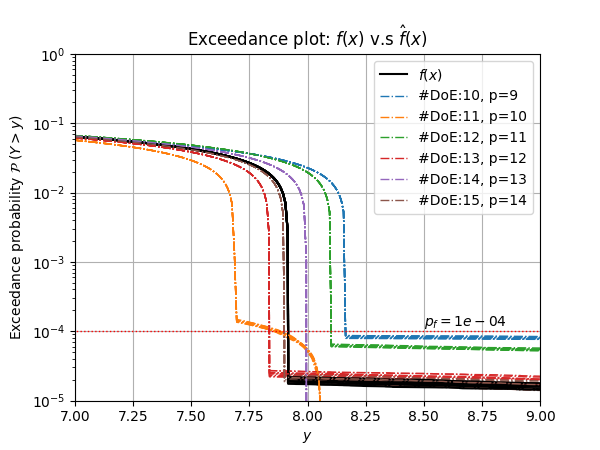

In [70]:
metamodel_class, metamodel_basis= ['PCE', list(np.arange(10,16))]
# ndoe2plot = list(np.arange(10,16))
ndoe2plot = list(np.arange(10,16))
label_added =False
fig2 = plt.figure(figsize=figsize)
ax2 = fig2.add_subplot(1,1,1)
for r in range(9):
    #Ture model emperical exceedance plot with mcs results
    iecdf = np.load(os.path.join(MODEL_DIR_DATA,noise_type,r'Bench1_noise_free_MC_DoE{}_ecdf.npy'.format(r)))
#     print(iecdf.shape)
    if not label_added:
        ax2.semilogy(iecdf[0,:], 1-iecdf[1,:],'k', label=r'$f(x)$')
    else:
        ax2.semilogy(iecdf[0,:], 1-iecdf[1,:],'k')  
#     y = np.logspace(-2, 0, 10, endpoint=True)
#     x = 0 * y
#     ax2.semilogy(x,y,'ko', label=r'$f(x)$')
#     y_ecdf = np.load('test.npy')
#     ax2.semilogy(y_ecdf[0,:], 1-y_ecdf[1,:],'ko', label=r'$f(x)$')
    for i, idoe in enumerate(ndoe2plot):
        # PCE model emperical exceedance plot with mcs results
        iecdf = np.load(os.path.join(MODEL_DIR_DATA,noise_type,r'PCE_Quadrature_DoE{}_MCS{}_ecdf.npy'.format(idoe,r)))
#         print(iecdf.shape)
        if not label_added:
            ax2.semilogy(iecdf[0,:], 1-iecdf[1,:],'-.',color=pltcolors[i],linewidth=1,label=r'#DoE:{}, p={}'.format(idoe,idoe-1))
        else:
            ax2.semilogy(iecdf[0,:], 1-iecdf[1,:],'-.',color=pltcolors[i],linewidth=1)   
#         # GPR model emperical exceedance plot with mcs results
#         iecdf = np.load(os.path.join(MODEL_DIR_DATA,noise_type,r'GPR_Uniform_DoE{}_MCS{}_ecdf.npy'.format(idoe, r)))
#         if not label_added:
#             ax2.semilogy(iecdf[0,:], 1-iecdf[1,:],'-.',color=pltcolors[i],linewidth=1,label=r'GPR RBF:')
#         else:
#             ax2.semilogy(iecdf[0,:], 1-iecdf[1,:],'-.',color=pltcolors[i],linewidth=1)  
    label_added =True
       
# plt.semilogy(ecdf_y.x,1-ecdf_y.y, 'k',label=r'exact')
# plt.semilogy(ecdf_y_norm.x,1-ecdf_y_norm.y, '-.r',label=r'normal error')
# print(ecdf_y_pce)
# for iecdf in ecdf_y_pce:
ax2.set_xlim(0,60)
ax2.set_ylim(1e-5,1)
xmin, xmax = ax2.get_xlim()
ymin, ymax = ax2.get_ylim()
ax2.plot([xmin,xmax],[pf,pf],':r',linewidth=1)
ax2.text(xmax*0.8,pf*1.2,r'$p_f={:.0e}$'.format(pf))

ax2.set_xlabel(r'$y$')
ax2.set_ylabel(r'Exceedance probability $\mathcal{P}\;(Y>y)$')
ax2.set_title(r'Exceedance plot: $f(x)$ v.s $\hat{f}(x)$')
plt.legend()
plt.grid()
# plt.show()
plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'ExceedancePlot_{}_Quadrature_DoE{}_{}.pdf'.format(metamodel_class,ndoe2plot[0],ndoe2plot[-1])))


In [71]:
ax2.set_xlim(7,9)
# ax2.set_ylim(0.8*pf,1.2*pf)
ax2.text(8.5,pf*1.2,r'$p_f={:.0e}$'.format(pf))
plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'ExceedancePlot_{}_Quadrature_DoE{}_{}_zoomin.pdf'.format(metamodel_class,ndoe2plot[0],ndoe2plot[-1])))


<IPython.core.display.Javascript object>


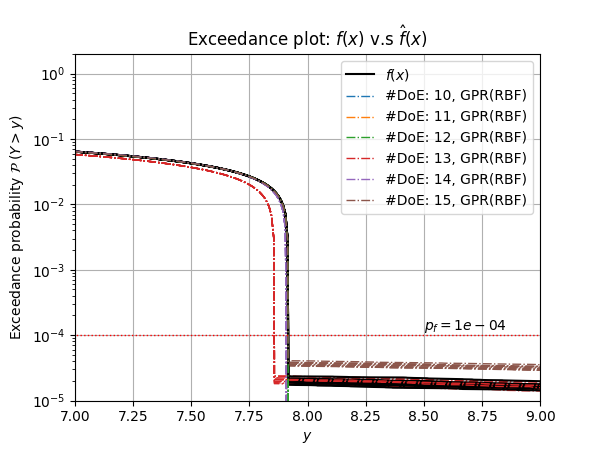

In [76]:
metamodel_class, metamodel_basis = ['GPR', ['RBF']]
ndoe2plot = list(np.arange(10,16))
# ndoe2plot = [10]
label_added =False
fig2 = plt.figure(figsize=figsize)
ax2 = fig2.add_subplot(1,1,1)
for r in range(10):
    # Ture model emperical exceedance plot with mcs results
    iecdf = np.load(os.path.join(MODEL_DIR_DATA,noise_type,r'Bench1_noise_free_MC_DoE{}_ecdf.npy'.format(r)))
    if not label_added:
        ax2.semilogy(iecdf[0,:], 1-iecdf[1,:],'k', label=r'$f(x)$')
    else:
        ax2.semilogy(iecdf[0,:], 1-iecdf[1,:],'k')  
        
    
    
    for i, idoe in enumerate(ndoe2plot):
#         # PCE model emperical exceedance plot with mcs results
#         iecdf = np.load(os.path.join(MODEL_DIR_DATA,noise_type,r'PCE_Quadrature_DoE{}_MCS{}_ecdf.npy'.format(idoe,r)))
#         if not label_added:
#             ax2.semilogy(iecdf[0,:], 1-iecdf[1,:],'-.',color=pltcolors[i],linewidth=1,label=r'PCE order: {}'.format(idoe-1))
#         else:
#             ax2.semilogy(iecdf[0,:], 1-iecdf[1,:],'-.',color=pltcolors[i],linewidth=1)   
        # GPR model emperical exceedance plot with mcs results
        iecdf = np.load(os.path.join(MODEL_DIR_DATA,noise_type,r'GPR_Uniform_DoE{}_MCS{}_ecdf.npy'.format(idoe, r)))
        if not label_added:
            ax2.semilogy(iecdf[0,:], 1-iecdf[1,:],'-.',color=pltcolors[i],linewidth=1,label=r'#DoE: {}, GPR(RBF)'.format(idoe))
        else:
            ax2.semilogy(iecdf[0,:], 1-iecdf[1,:],'-.',color=pltcolors[i],linewidth=1)  
    label_added =True
       
# plt.semilogy(ecdf_y.x,1-ecdf_y.y, 'k',label=r'exact')
# plt.semilogy(ecdf_y_norm.x,1-ecdf_y_norm.y, '-.r',label=r'normal error')
# print(ecdf_y_pce)
# for iecdf in ecdf_y_pce:
ax2.set_xlim(0,60)
ax2.set_ylim(1e-5,2)
xmin, xmax = ax2.get_xlim()
ymin, ymax = ax2.get_ylim()
ax2.plot([xmin,xmax],[pf,pf],':r',linewidth=1)
ax2.text(xmax*0.8,pf*1.2,r'$p_f={:.0e}$'.format(pf))

ax2.set_xlabel(r'$y$')
ax2.set_ylabel(r'Exceedance probability $\mathcal{P}\;(Y>y)$')
ax2.set_title(r'Exceedance plot: $f(x)$ v.s $\hat{f}(x)$')
plt.legend()
plt.grid()
plt.show()
plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'ExceedancePlot_{}_Quadrature_DoE{}_{}.pdf'.format(metamodel_class,ndoe2plot[0],ndoe2plot[-1])))


In [77]:
ax2.set_xlim(7,9)
# ax2.set_ylim(0.8*pf,1.2*pf)
ax2.text(8.5,pf*1.2,r'$p_f={:.0e}$'.format(pf))
plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'ExceedancePlot_{}_Quadrature_DoE{}_{}_zoomin.pdf'.format(metamodel_class,ndoe2plot[0],ndoe2plot[-1])))


### 2   Benchmark 1

In [ ]:
label_added =False
fig = plt.figure(figsize=(4*1.5,3*1.5))
ax = fig.add_subplot(1,1,1)
print(len(true_y_mcs_ecdf2plot))
for iecdf2plot in true_y_mcs_ecdf2plot:
    if not label_added:
        ax.semilogy(iecdf2plot.x, 1-iecdf2plot.y,'k', label=r'$f(x)$')
        label_added =True
    else:
        ax.semilogy(iecdf2plot.x, 1-iecdf2plot.y,'k')    
label_added =False    
for imetamodel_ecdfs in metamodel_y_gpr_mcs_ecdf2plot:
    iecdf2plot = imetamodel_ecdfs
   
    if not label_added:
        ax.semilogy(iecdf2plot.x, 1-iecdf2plot.y,'-.',color='b',linewidth=1, label=r'GPR RBF:')
        label_added =True
    else:
        ax.semilogy(iecdf2plot.x, 1-iecdf2plot.y,'-.',color='b',linewidth=1)
#     print(i)
        
# plt.semilogy(ecdf_y.x,1-ecdf_y.y, 'k',label=r'exact')
# plt.semilogy(ecdf_y_norm.x,1-ecdf_y_norm.y, '-.r',label=r'normal error')
# print(ecdf_y_pce)
# for iecdf in ecdf_y_pce:

ax.set_xlim(0,80)
ax.set_ylim(1e-5,2)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.plot([xmin,xmax],[pf,pf],'-.r')
ax.text(5,pf*1.2,r'$p_f={:.0e}$'.format(pf))

ax.set_xlabel(r'$y$')
ax.set_ylabel(r'Exceedance probability $\mathcal{P}\;(Y>y)$')
ax.set_title(r'Exceedance plot: $f(x)$ v.s $\hat{f}(x)$')
plt.legend()
plt.grid()
plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'ExceedancePlot_{}_DoE0.pdf'.format(metamodel_class)))

In [ ]:
x_fix = np.linspace(-5,15,1000)[np.newaxis, :]
metamodel_class, metamodel_basis = ['GPR', 'RBF']

data_set = np.load(os.path.join(MODEL_DIR_DATA,'Noise_free',r'True_domain_FIX_DoE_fix0.npy'))
x,y = data_set[0].T,data_set[1].T
# print(data_set[0].shape, data_set[1].shape)
# print(x.shape, y.shape)
plt.figure()
plt.plot(x,y,'k',label=r'f(x)')
data_set = np.load(os.path.join(MODEL_DIR_DATA,'Noise_free',r'aDoE_Quadrature_hermite_train_GPR0.npy'))
print(len(data_set))
x_train    = np.squeeze(data_set[0][0])
x_weight   = np.squeeze(data_set[0][1])
y_train    = np.squeeze(data_set[1])
zeta_train = np.squeeze(data_set[2][0])
y_validate = np.squeeze(data_set[3][0,:])
y_valid_std= np.squeeze(data_set[3][1,:])
x_test     = np.squeeze(data_set[4])
y_test_mean= np.squeeze(data_set[6][0,:])
y_test_std = np.squeeze(data_set[6][1,:])
print(data_set[3].shape)
print(x_train.shape,y_validate.shape)
plt.plot(x_train,y_train,'rx',zorder=9, label=r'Training Data')

plt.plot(x_train,y_validate,'o', markeredgecolor='b', markerfacecolor='w', label=r'GPR: RBF')

plt.plot(x_test,y_test_mean,'-', color='b')
plt.fill_between(x_test, y_test_mean - 1.96*y_test_std, y_test_mean + 1.96*y_test_std,
                 color='b',alpha=0.2,edgecolor='None',label='95% confidence interval')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'{} surrogate model: {} $(\epsilon=0)$'.format(metamodel_class,MODEL_NAME))
plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'{}_DoE0.pdf'.format(metamodel_class)))

In [ ]:
metamodel_y_mcs_ecdf = [[] for _ in range(len(metamodel_basis))] 
metamodel_y_mcs_ecdf2plot = [[] for _ in range(len(metamodel_basis))]
print(data_set.shape)
metamodel_zeta_mcs = data_set[:,0]
metamodel_y_mcs    = data_set[:,1]
print(metamodel_y_mcs[0].shape)

for metamodel_zeta_mcs_r in metamodel_zeta_mcs:
    for i, imetamodel_zeta_mcs in enumerate(metamodel_zeta_mcs_r):
        print(np.round(imetamodel_zeta_mcs[:5],4))

for metamodel_y_mcs_r in metamodel_y_mcs:
    for i, imetamodel_y_mcs in enumerate(metamodel_y_mcs_r):
        iecdf = ECDF(np.squeeze(imetamodel_y_mcs))
        metamodel_y_mcs_ecdf[i].append(iecdf)
        
        indx1 = np.linspace(0,len(iecdf.x)-windowlength2plot, windowlength2plot, dtype=np.int32)
        indx2 = np.arange(indx1[-1]+1,len(iecdf.x),dtype=np.int32)
        indx  = np.hstack((indx1,indx2))
        metamodel_y_mcs_ecdf2plot[i].append(Ecdf2plot(iecdf.x[indx],iecdf.y[indx]))


In [ ]:
plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'ExceedancePlot_{}_DoE0_zoomin.pdf'.format(metamodel_class)))


In [ ]:
plt.figure(figsize=(4*1.5, 3*1.5))
plt.subplot(1, 1, 1)
kernel  = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e4))
lim,res = [-5,20], 191
rng = np.random.RandomState(3)
# Training Data
x_fix = np.linspace(-5,15,1000)[np.newaxis, :]

data_set = np.load(os.path.join(MODEL_DIR_DATA,'Noise_free',r'True_domain_FIX_DoE_fix0.npy'))
x,y = data_set[0].T,data_set[1].T
# print(data_set[0].shape, data_set[1].shape)
plt.plot(x,y,'k',label=r'f(x)')
data_set = np.load(os.path.join(MODEL_DIR_DATA,'Noise_free',r'Train_Quadrature_hermite_PCE_doe0.npy'))
x_train    = data_set[0][0]
x_weight   = data_set[0][1]
y_train    = data_set[1]
zeta_train = data_set[2][0]
y_validate = data_set[3]
y_fix      = data_set[4]
# print(y_fix.shape)
plt.plot(x_train.T,y_train.T,'rx',zorder=9, label=r'Training Data')
print(x_fix.shape)



# Plot prior      
# Specify Gaussian Process
gp = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10)
#     y_mean, y_std = gp.predict(x_fix.T, return_std=True)
#     plt.plot(x_fix.T, y_mean, 'b-', zorder=9,label=r'Prediction')

#     plt.fill_between(np.squeeze(x_fix), y_mean - 1.96*y_std, y_mean + 1.96*y_std,
#                      color='b',alpha=0.2,edgecolor='None',label='95% confidence interval')

#     y_samples = gp.sample_y(X_[:, np.newaxis], 5)
#     plt.plot(X_, y_samples, '-.', lw=1,alpha=0.5)
# #     plt.ylim(-20,20)
# #     plt.fill_between(np.array([14,lim[1]]),np.array([20,20]),np.array([-20,-20]),'k',alpha=0.3)
#     plt.xlim(lim[0],lim[1])
# #     plt.ylim(-3, 3)
#     plt.xlabel("x")
#     plt.ylabel("y")
#     kernel_params = kernel.get_params()
#     kernel_str = "(RBF: $\sigma^2={:.2f}, l={:.2f}$)".format(kernel_params['k1__constant_value'],kernel_params['k2__length_scale'])
#     plt.title("Prior\n"+kernel_str)
#     plt.legend(loc=2)
#     plt.tight_layout()
#     plt.savefig("../Figures/GPR_RBF_prior.pdf")

#     # Plot posterior
#     plt.figure(figsize=(4*1.5, 3*1.5))
#     plt.subplot(1, 1, 1)
#     plt.plot(X_, y_, 'k', label=u'$f(x)=x\,\sin(x)$')
#     plt.plot(X_train,y_train, 'rs',markersize=4, label=r'Observations', zorder=9)
#     #  fit GP
gp.fit(x_train.T, np.squeeze(y_train))
y_mean, y_std = gp.predict(x_fix.T, return_std=True)

plt.plot(x_fix.T, y_mean, 'b', lw=2, zorder=8,label=r'Prediction') 
plt.fill_between(np.squeeze(x_fix), y_mean - 1.96*y_std, y_mean +  1.96*y_std,
                 color='b',alpha=0.2,edgecolor='None',
                 label='95% confidence interval')
kernel_params = gp.kernel_.get_params()
kernel_str = "(RBF: $\sigma^2={:.2f}, l={:.2f}$)".format(kernel_params['k1__constant_value'],kernel_params['k2__length_scale'])
plt.title("Posterior\n"+kernel_str)




#     plt.xlim(lim[0],lim[1])
#     plt.xlabel("x")
#     plt.ylabel("y")
#     kernel_params = gp.kernel_.get_params()
#     kernel_str = "(RBF: $\sigma^2={:.2f}, l={:.2f}$)".format(kernel_params['k1__constant_value'],kernel_params['k2__length_scale'])    

#     plt.title("Posterior\n"+kernel_str)
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig("../Figures/GPR_RBF_posterior.pdf")
print(gp.kernel_.theta)
print(np.exp(gp.kernel_.theta))    

In [ ]:
a = np.arange(10)
b = np.arange(10).reshape(10,1)
# a = a.reshape(b.shape)
print(a.shape,b.shape)
c = np.hstack((a.reshape(b.shape),b)).T
print(c.shape)

In [ ]:
a =np.arange(10).reshape(2,5)
print(a.reshape(10,-1).shape)

In [ ]:
windowlength2plot       = 1000
metamodel_gp_y_mcs_ecdf = [] 
metamodel_gp_y_mcs_ecdf2plot = [] 
for r in range(10):
    data_set = np.load(os.path.join(MODEL_DIR_DATA,'Noise_free',r'True_MCS_R_DoE{}.npy'.format(r)))
    metamodel_gp_x_mcs    = data_set[0][0]
    metamodel_gp_mcs      = data_set[1]
    metamodel_gp_zeta_mcs = data_set[2][0]
    print(metamodel_gp_x_mcs.shape)
    metamodel_gp_y_samples= gp.sample_y(metamodel_gp_x_mcs[:10000,np.newaxis])
    iecdf = ECDF(np.squeeze(metamodel_gp_y_samples))
    metamodel_gp_y_mcs_ecdf.append(iecdf)
    
    indx1 = np.linspace(0,len(iecdf.x)-windowlength2plot, windowlength2plot, dtype=np.int32)
    indx2 = np.arange(indx1[-1]+1,len(iecdf.x),dtype=np.int32)
    indx  = np.hstack((indx1,indx2))
    metamodel_gp_y_mcs_ecdf2plot.append(Ecdf2plot(iecdf.x[indx],iecdf.y[indx]))
#     print(np.round(true_zeta_mcs[:5],4))
    
#     metamodel_zeta_mcs = data_set[2]
    






In [ ]:

# print(kernel_params)
# theta = [signal variance, length_scale, noise_variace, noise level]
res = 100
sigma_f        = kernel_params['k1__k1__constant_value']
length_scale   = np.logspace(-3,3,res)
noise_variance = kernel_params['k2__k1__constant_value']
noise_level    = np.logspace(-3,3,res)
# theta1 = np.logspace(-1,1,10)
Theta1, Theta3 = np.meshgrid(length_scale, noise_level)
print(Theta1.shape)
# LML = np.array([[gp.log_marginal_likelihood(np.log([Theta1[i, j], Theta3[i, j]]))
#     for i in range(Theta1.shape[0])] for j in range(Theta1.shape[1])])
LML = np.array([[gp.log_marginal_likelihood(np.log([sigma_f, Theta1[i, j], noise_variance, Theta3[i, j]]))
    for i in range(Theta1.shape[0])] for j in range(Theta1.shape[1])])
print(LML.shape)
vmin, vmax = (-LML).min(), (-LML).max()
vmax = 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), 50), decimals=1)

plt.figure(figsize=(4*1.5, 3*1.5))
plt.contour(Theta1, Theta3, -LML,levels=level,norm=LogNorm(vmin=vmin,vmax=vmax))
theta_opt = np.exp(gp.kernel_.theta)
plt.plot(theta_opt[1],theta_opt[3],'r+')
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"Length-scale $l$")
plt.ylabel(r"Noise-level $\sigma_n$")
plt.title(r"$-\log(p(y|X,\theta,\mathcal{H}_i))$")
plt.savefig("../Figures/GPR_RBF_WN_LML_noise_level_length_scale.pdf")
plt.tight_layout()



In [ ]:
a = y_mean.T - 1.96*y_std.T
print(a.shape)

In [ ]:
pf = 1e-4
x_mu, x_sigma = 5,2
dist_x    = cp.Normal(x_mu, x_sigma) # normal mean = 0, normal std=0.25
dist_zeta = cp.Normal()
x_cr      = dist_x.inv(1-pf) ## Critical value corresponding to failure prob pf
nstd_from_mean = np.ceil((x_cr-x_mu)/x_sigma)+1
x = np.linspace(x_mu-nstd_from_mean*x_sigma, x_mu+nstd_from_mean*x_sigma,1000)
y_mean = f(x)
error = abs(y_mean)/5

# plt.plot([x_cr,x_cr], [0,f([x_cr])])
# plt.plot([2*x_mu-x_cr,2*x_mu-x_cr], [0,f([x_cr])])
# print(x_cr,nstd_from_mean)
# print(training_x.shape,weight_xy.shape,training_y.shape)

In [ ]:
plt.savefig(os.path.join(MODEL_DIR_FIGURE, r'ECDF_Bench4.pdf'))

In [ ]:
plt.figure()
plt.plot(x,y_mean,'k',label=r'$f(x)$')
plt.fill_between(x, y_mean+error,y_mean-error,color='k',alpha=0.3)
# print(x.shape,y_true.shape)
# data_set = np.load(os.path.join(MODEL_DIR_DATA,r'Quadrature_hermite_doe0.npy'))
# training_zeta = data_set[3]
# training_x = data_set[0]
# weights_xy = data_set[1]
# y_obs_mean = f(training_x)

# error_sigma= abs(y_obs_mean)/5
# error_type = ErrorType('normal',[0,error_sigma.T])
# y_norm     = f(training_x, error_type)

# error_type = ErrorType('weibull',[1,0.3])
# y_weib = f(training_x, error_type)
# error_type = ErrorType('gumbel',[1,0.3])
# y_gumb = f(training_x, error_type)
# plt.plot(training_x.T,y_obs_mean, 'kx')#,label=r'Observations ($\epsilon\sim p(\epsilon))$')
# plt.plot(training_x.T,y_norm, 'rs',label=r'Observations ($\epsilon\sim p(\epsilon))$')
# plt.plot(training_x.T,y_weib, 'bs',label=r'weibull')
# plt.plot(training_x.T,y_gumb, 'gs',label=r'gumble')
plt.xlabel(r'$x \sim \mathcal{N}(5,2)$')
plt.ylabel(r'$y$')
plt.legend()

In [ ]:
np.random.seed(100)
nsamples  = int(100*1/pf)

x_samples = np.random.normal(x_mu,x_sigma,nsamples)
y_samples = f(x_samples)
ecdf_y    = ECDF(y_samples)

error_sigma    = abs(y_samples)/5
error_type     = ErrorType('normal',[0,error_sigma.T])
y_norm_samples = f(x_samples, error_type)
ecdf_y_norm    = ECDF(y_norm_samples)

In [ ]:
sns.jointplot(x_samples, y_samples,kind='reg')
plt.xlabel(r'$x \sim \mathcal{N}(5,5)$')
plt.ylabel(r'$y$')

In [ ]:
zeta_samples = dist_zeta.inv(dist_x.cdf(x_samples))
plt.figure()
sns.distplot(zeta_samples,color='k',label=r'$\zeta$');
zeta = np.linspace(-5,5,100)
plt.plot(zeta,dist_zeta.pdf(zeta),label=r'$\mathcal{N}(0,1)$')
plt.legend()


In [ ]:
orthpoly_orders = np.arange(1,10)
training_y   = y_obs_mean
metamodels   = []
f_orth_coeffs= []
f_preds      = []

print(training_zeta.shape, weights_xy.shape, training_y.shape)
print(zeta_samples.shape)
for iorthpoly_order in orthpoly_orders:
#     print(orthpoly_order_i)
    orth_poly, norms = cp.orth_ttr(iorthpoly_order, dist_zeta, retall=True)
    f_hat, coeffs = cp.fit_quadrature(orth_poly, training_zeta, weights_xy, np.squeeze(training_y), retall=True,norms=norms)
    f_preds.append(f_hat(zeta_samples))
    metamodels.append(f_hat)
    f_orth_coeffs.append(coeffs)


In [ ]:
print(len(f_preds))
fig1 = plt.figure(figsize=(8,6))
ax1  = fig1.add_subplot(1,1,1)
ax1.plot(x,y_mean,'k',label=r'True $(\epsilon=0)$')
# ax1.fill_between(x, y_mean+error,y_mean-error,color='k',alpha=0.3)
iorder = 1
for f_pred in f_preds:
#     lists = sorted(zip(*[x_samples, f_pred]))
#     x, y = list(zip(*lists))
    ax1.plot(x_samples, f_pred, 'o', markersize=1,label='{}'.format(iorder))
    iorder += 1
ax1.legend()
ax1.set_xlim(-5,15)
ax1.set_ylim(-50,120)

In [ ]:
# print(f_preds)
ecdf_y_pce = [ECDF(f_pred) for f_pred in f_preds]
plt.figure(figsize=(8,6))
plt.semilogy(ecdf_y.x,1-ecdf_y.y, 'k',label=r'exact')
plt.semilogy(ecdf_y_norm.x,1-ecdf_y_norm.y, '-.r',label=r'normal error')
# print(ecdf_y_pce)
for iecdf in ecdf_y_pce:
    plt.semilogy(iecdf.x, 1-iecdf.y)
plt.xlim(0,300)
plt.legend()

### 2. Periodic function 
\begin{equation}
f=x \sin(x) + \epsilon,\quad x \sim \mathcal{N}\,(5,5), \quad \epsilon \sim p(\epsilon)
\end{equation}


In [ ]:
def bench1(x, error_type=ErrorType()):
    x = np.array(x)           
    error = gen_error(len(x), error_type)
    print(error_type.name)
    y0 = x * np.sin(x)
    y = y0 + error
    return y.T

In [ ]:
x = np.linspace(-5,20,191)
y_true = bench1(x)
print(x.shape,y_true.shape)

In [ ]:
error_type = ErrorType('normal',[1,1])
y_norm = bench1(x,error_type)
error_type = ErrorType('weibull',[1,1])
y_weib = bench1(x,error_type)
error_type = ErrorType('gumbel',[1,1])
y_gumb = bench1(x,error_type)

In [ ]:
plt.figure()
plt.plot(x,y_true,'k',label='True model')
plt.plot(x,y_norm,label=r'$\epsilon \sim \mathcal{N}\,(1,1)$')
plt.plot(x,y_weib,label=r'$\epsilon \sim \mathcal{Weibull}\,(1,1)$')
plt.plot(x,y_gumb,label=r'$\epsilon \sim \mathcal{Gumbel}\,(1,1)$')
plt.legend()

In [ ]:
nsamples = int(1e6)
np.random.seed(100)
x_samples = np.random.normal(5,5,nsamples)
y_samples = bench1(x_samples)
ecdf      = ECDF(y_samples)

error_type     = ErrorType('normal',[1,1])
y_norm_samples = bench1(x_sampels,error_type)
ecdf_norm      = ECDF(y_norm_samples)

error_type     = ErrorType('weibull',[1,1])
y_weib_samples = bench1(x_sampels,error_type)
ecdf_weib      = ECDF(y_weib_samples)

error_type     = ErrorType('gumbel',[1,1])
y_gumb_samples = bench1(x_sampels,error_type)
ecdf_gumb      = ECDF(y_gumb_samples)

In [ ]:
plt.figure()
plt.plot(x,y_true,'k',label='True model',zorder=9)
plt.plot(x_sampels,y_norm_samples,'ro',markersize=1,alpha=0.1,zorder=8)
plt.plot(x_sampels,y_weib_samples,'bo',markersize=1,alpha=0.1)
plt.plot(x_sampels,y_gumb_samples,'go',markersize=1,alpha=0.1)
plt.legend()

In [ ]:
import seaborn as sns
# hist_true = np.histogram(y_samples)
# hist_norm = np.histogram(y_norm_samples)
# hist_weib = np.histogram(y_weib_samples)
# hist_gumb = np.histogram(y_gumb_samples)

plt.figure()
sns.distplot(y_samples,color='k',label='True');
sns.distplot(y_norm_samples,label='normal');
sns.distplot(y_weib_samples,label='weibull');
sns.distplot(y_gumb_samples,label='gumbel');
plt.legend()
# plt.hist(y_samples,bins=30,color='k',alpha=0.1)
# plt.hist(y_norm_samples,bins=30,color='r',alpha=0.5)
# plt.hist(y_weib_samples,bins=30,color='b',alpha=0.5)
# plt.hist(y_gumb_samples,bins=30,color='g',alpha=0.5)

In [ ]:
plt.figure(figsize=(4,3))
plt.semilogy(ecdf.x,1-ecdf.y, '-.k',label=r'exact')
plt.semilogy(ecdf_norm.x,1-ecdf_norm.y, '-.r',label=r'normal error')
plt.semilogy(ecdf_weib.x,1-ecdf_weib.y, '-.b',label=r'weibull error')
plt.semilogy(ecdf_gumb.x,1-ecdf_gumb.y, '-.g',label=r'gumble error')
# for j,i in enumerate(np.arange(0,len(x1_ecdf_hat),2)):
#     axes[1,0].semilogy(x1_ecdf_hat[i].x,1-x1_ecdf_hat[i].y,linestyle=pltlinestyles[j],color=pltcolors[0], label=r'${}$-order'.format(ordinal(i+1)))
#     axes[1,0].semilogy(x2_ecdf_hat[i].x,1-x2_ecdf_hat[i].y,linestyle=pltlinestyles[j],color=pltcolors[1])#, label=r'${}$-order'.format(i+1)

plt.xlabel(r'$u$')
plt.ylabel(r'$Probability$')
# plt.title(r'Exceedence probability $P(X>x_0)$')
# plt.ylim((10/nsamples,1))
plt.legend()
